# Task 3: Visualization on CNN

Load and configure the needed modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
from sklearn.manifold import TSNE

# inline plots
%matplotlib inline

Using Theano backend.


## Load the MNIST data.

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Set global values for training and network architecture

In [3]:
batch_size = 128
nb_classes = 10
nb_epoch = 10

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

A random gaussian noise is added to the MNIST dataset and a new dataset is created. The guassian noise has 0 mean and 0.2 std. It is applied to the dataset values which are compress between 0 and 1.

In [4]:
std = .2
# Create gaussian noise
gaussian_noise_train = np.random.normal(0,std,X_train.shape)
gaussian_noise_test = np.random.normal(0,std,X_test.shape)
# Create a new dataset with the noise
X_train_noise = X_train - gaussian_noise_train
X_test_noise = X_test - gaussian_noise_test
# Saturate the new dataset values to 1 as higher value and 0 as lowest value
X_train_noise[X_train_noise>1] = 1
X_test_noise[X_test_noise<0] = 0

Lets see some samples of the original dataset and the one with some gaussian noise

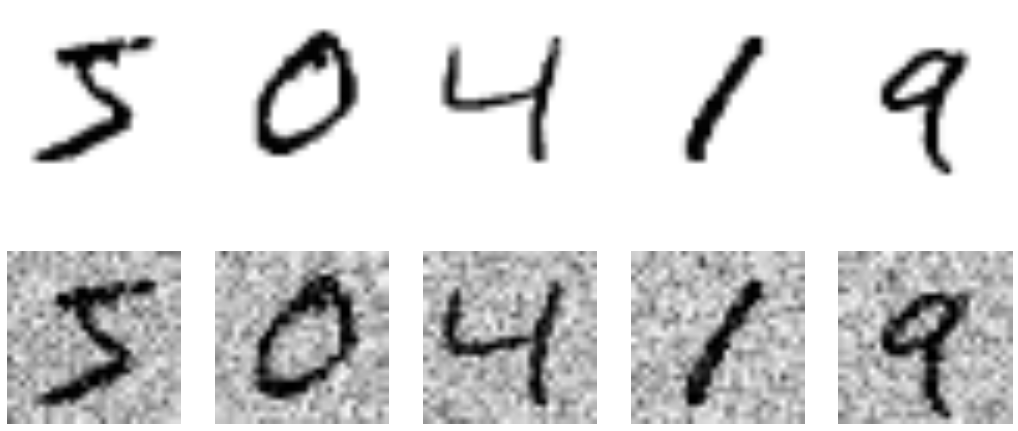

In [5]:
f, axarr = plt.subplots(2, 5, figsize=(18,8), dpi=100)
for i in range(5):
    axarr[0,i].imshow(X_train[i])
    axarr[0,i].get_xaxis().set_visible(False)
    axarr[0,i].get_yaxis().set_visible(False)
    axarr[1,i].imshow(X_train_noise[i])
    axarr[1,i].get_xaxis().set_visible(False)
    axarr[1,i].get_yaxis().set_visible(False)

## Train a Convolutional Neural Network

We need to reshape the images specifying it only has one single channel at the input (grayscale).

In [6]:
X_train_noise = X_train_noise.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test_noise = X_test_noise.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
print('X_train shape: {}'.format(X_train_noise.shape))
print('X_test shape: {}'.format(X_test_noise.shape))

X_train shape: (60000, 1, 28, 28)
X_test shape: (10000, 1, 28, 28)


We also need to convert the class labels to one hot encoding.

In [7]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Let's create a basic CNN with three conv layers, two max pooling and two dense layers.

In [8]:
input_ = Input(shape=(1, img_rows, img_cols))
conv1a = Convolution2D(32, nb_conv, nb_conv, activation='relu', name='conv1a')(input_)
conv1b = Convolution2D(32, nb_conv, nb_conv, activation='relu', name='conv1b')(conv1a)
pool1 = MaxPooling2D(pool_size=(nb_pool, nb_pool), name='pool1')(conv1b)
conv2 = Convolution2D(64, nb_conv, nb_conv, activation='relu', name='conv2')(pool1)
pool2 = MaxPooling2D(pool_size=(nb_pool, nb_pool), name='pool2')(conv2)
fc = Dense(128, activation='relu', name='fc')(Flatten()(pool2))
softmax = Dense(nb_classes, activation='softmax', name='softmax')(fc)

model = Model(input_, softmax)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 1, 28, 28)   0                                            
____________________________________________________________________________________________________
conv1a (Convolution2D)             (None, 32, 26, 26)  320         input_1[0][0]                    
____________________________________________________________________________________________________
conv1b (Convolution2D)             (None, 32, 24, 24)  9248        conv1a[0][0]                     
____________________________________________________________________________________________________
pool1 (MaxPooling2D)               (None, 32, 12, 12)  0           conv1b[0][0]                     
___________________________________________________________________________________________

Lets train the CNN with the noisy dataset

In [13]:
callbacks = [
    ModelCheckpoint('models/weights_noise.hdf5', save_best_only=True),
    EarlyStopping(patience=3)
]

history = model.fit(X_train_noise, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test_noise, Y_test), callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 317s - loss: 0.1973 - acc: 0.9384 - val_loss: 0.0533 - val_acc: 0.9822
Epoch 2/10
60000/60000 [==============================] - 319s - loss: 0.0467 - acc: 0.9851 - val_loss: 0.0357 - val_acc: 0.9889
Epoch 3/10
60000/60000 [==============================] - 313s - loss: 0.0290 - acc: 0.9909 - val_loss: 0.0397 - val_acc: 0.9876
Epoch 4/10
60000/60000 [==============================] - 336s - loss: 0.0199 - acc: 0.9940 - val_loss: 0.0441 - val_acc: 0.9864
Epoch 5/10
60000/60000 [==============================] - 365s - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0445 - val_acc: 0.9884
Epoch 6/10
60000/60000 [==============================] - 329s - loss: 0.0103 - acc: 0.9967 - val_loss: 0.0546 - val_acc: 0.9864


Now plot the loss and accuracy of training and validation subset during training.

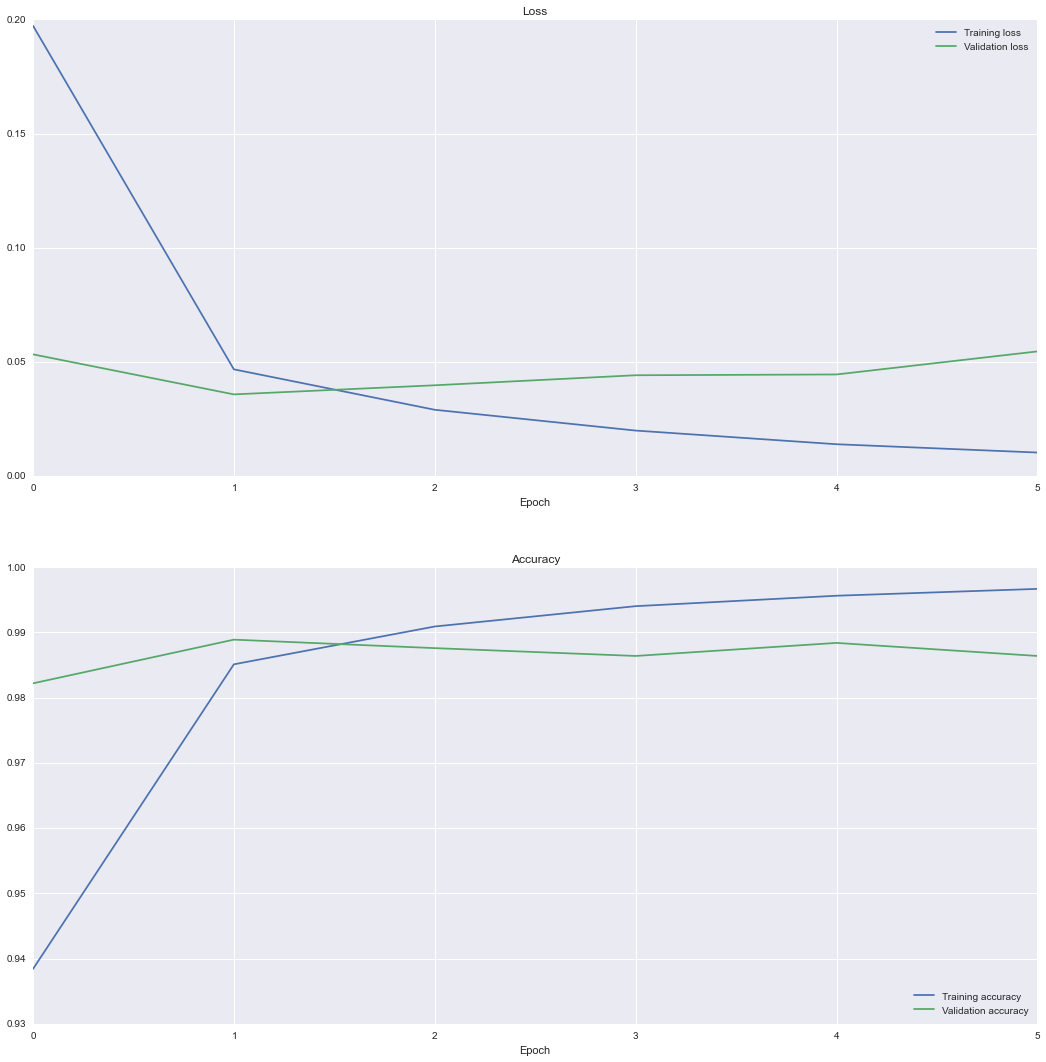

In [16]:
plt.figure(num=None, figsize=(18,18), dpi=100)
plt.subplot(2, 1, 1)
# Loss plot
plt.title('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
# Accuracy plot
plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend(loc='lower right')
plt.show()

In the case you don't want to train and load the weights directly run the following command:

In [9]:
model.load_weights('models/weights_noise.hdf5')

Given the network trained with the noise dataset, lets compare the accuracy for the noise dataset and the original one.

In [10]:
_, accuracy_original = model.evaluate(X_test, Y_test)
_, accuracy_noise = model.evaluate(X_test_noise, Y_test)
print('Accuracy Noisy Dataset: {:.4f}'.format(accuracy_noise))
print('Accuracy Original Dataset: {:.4f}'.format(accuracy_original))

10000/10000 [==============================] - 16s    
Accuracy Noisy Dataset: 0.9879
Accuracy Original Dataset: 0.9900


## Network Visualization

Now lets visualize the inside of the CNN trained before, as also the output at each stage.

First lets retrieve the fiters of the first conv layer, which are the most important to represent as are the ones which are applied to the input images

In [11]:
# Extract the filters weights
filters = model.get_layer('conv1a').get_weights()[0]
print('Filters shape: {}'.format(filters.shape))

Filters shape: (32, 1, 3, 3)


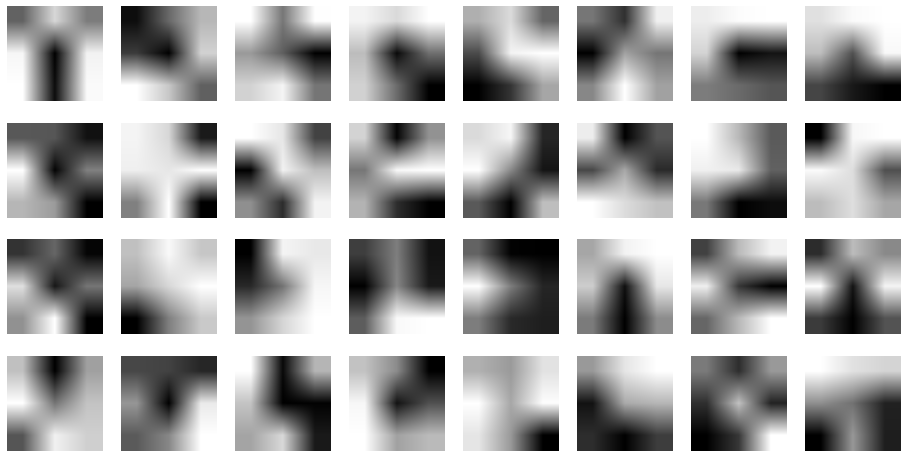

In [12]:
f, axarr = plt.subplots(4, 8, figsize=(16, 8), dpi=100)
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(filters[i*8+j,0])
        axarr[i,j].get_xaxis().set_visible(False)
        axarr[i,j].get_yaxis().set_visible(False)

Next step is to put an image at the input and observe which are the output at each of the convolutional layers.

Lets see the image at the input.

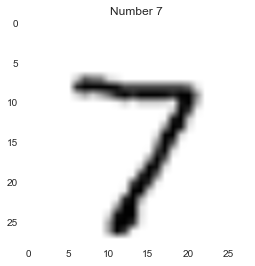

In [13]:
idx = 0
plt.imshow(X_test[idx][0])
plt.grid(False)
plt.title('Number {}'.format(y_test[idx]))

In [14]:
m_conv1a = Model(input_, conv1a)
m_conv1b = Model(input_, conv1b)
m_conv2 = Model(input_, conv2)

output_noise = {}
output_noise['conv1a'] = m_conv1a.predict([X_test_noise[idx:idx+1]])
output_noise['conv1b'] = m_conv1b.predict([X_test_noise[idx:idx+1]])
output_noise['conv2'] = m_conv2.predict([X_test_noise[idx:idx+1]])

output_original = {}
output_original['conv1a'] = m_conv1a.predict([X_test[idx:idx+1]])
output_original['conv1b'] = m_conv1b.predict([X_test[idx:idx+1]])
output_original['conv2'] = m_conv2.predict([X_test[idx:idx+1]])

Upper: noisy input
Bottom: original input
Layer conv1a


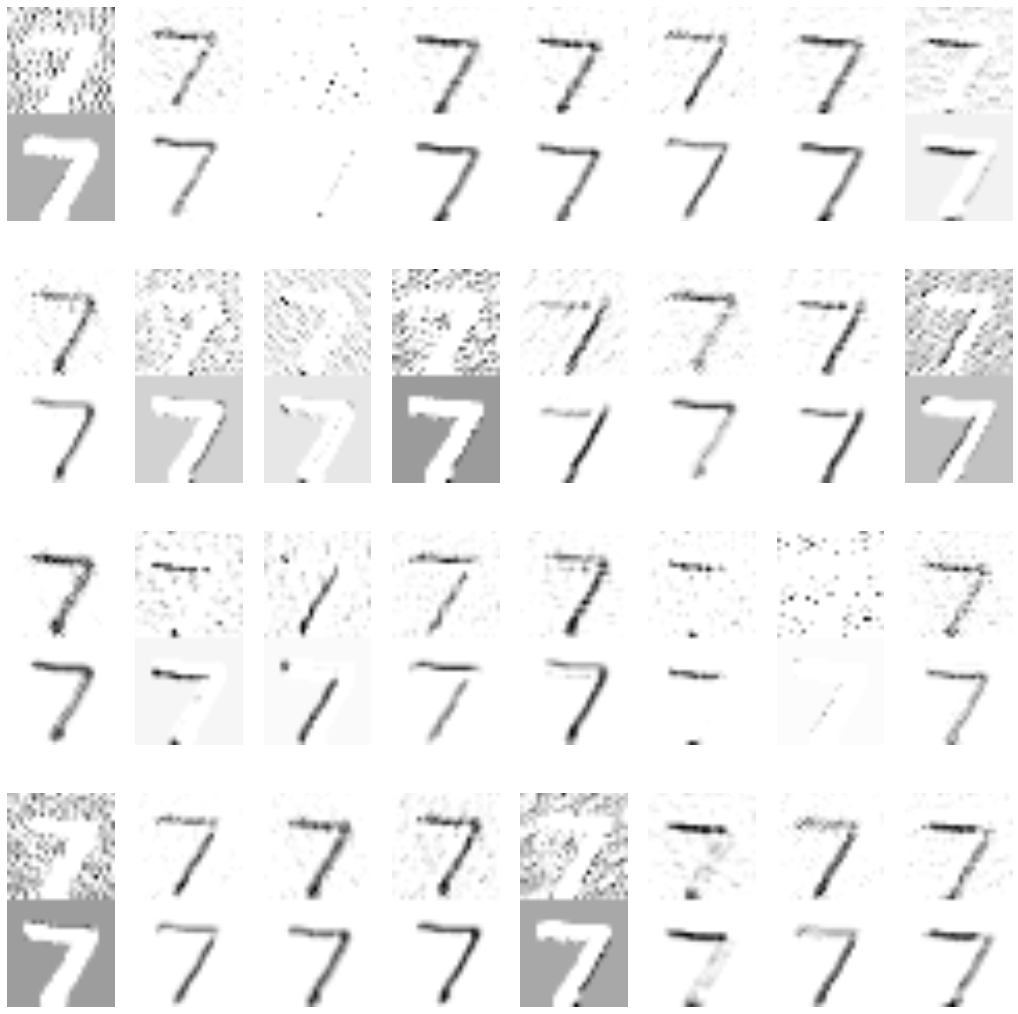

Layer conv1b


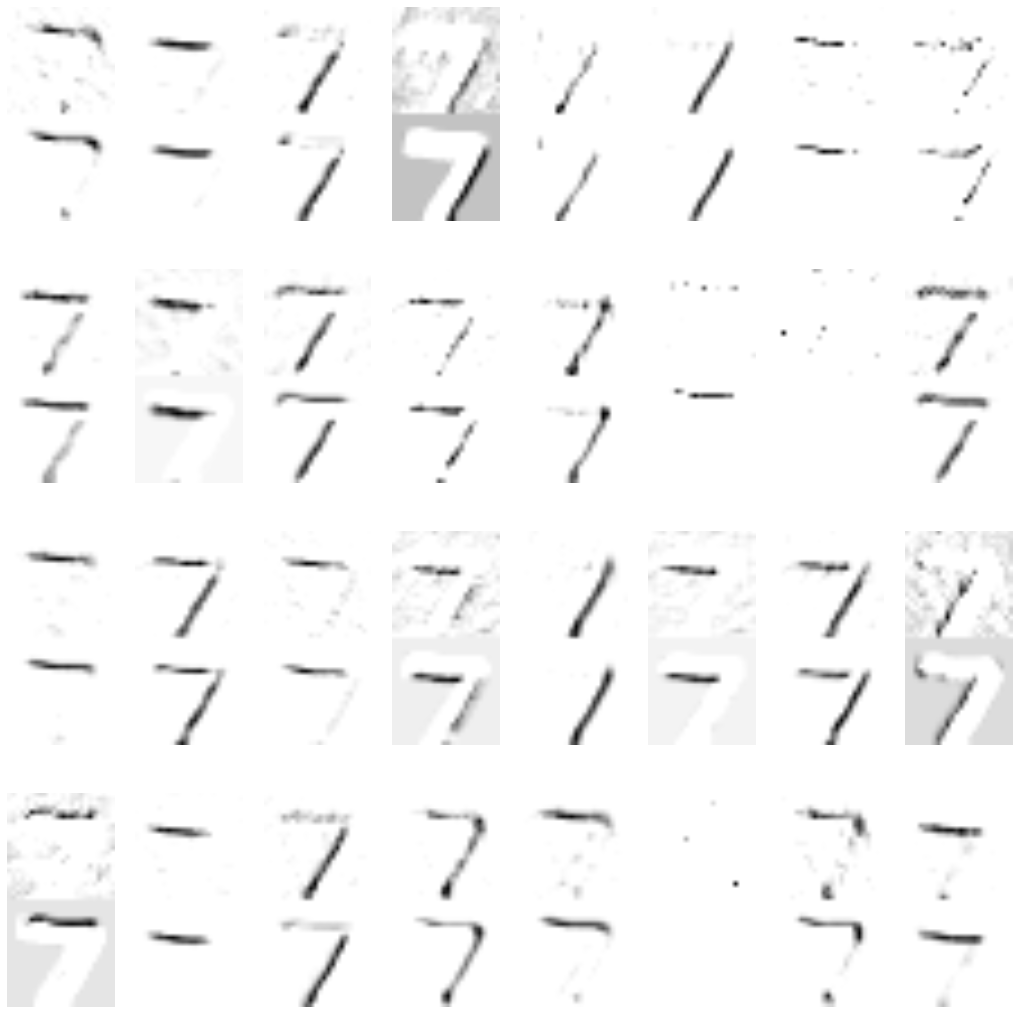

Layer conv2


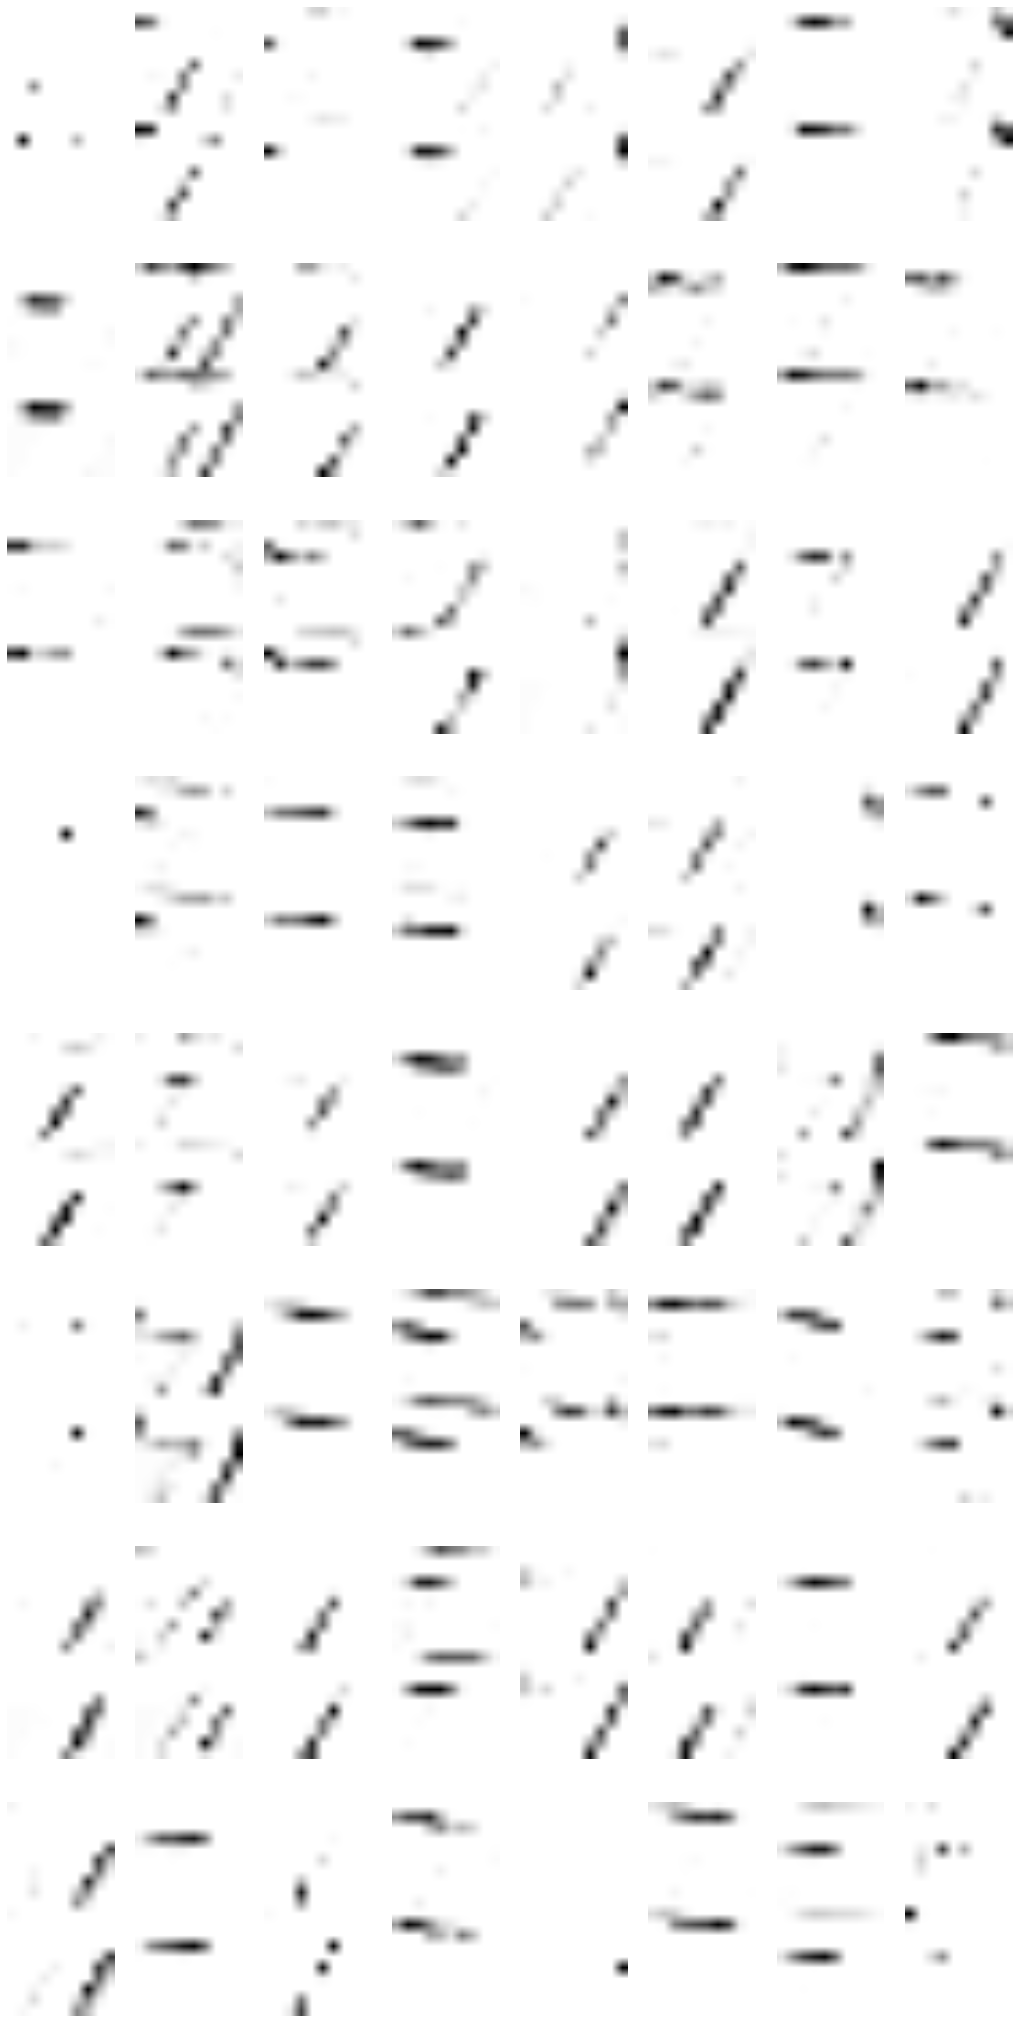

In [15]:
print('Upper: noisy input')
print('Bottom: original input')

for layer in ('conv1a', 'conv1b', 'conv2'):
    
    print('Layer {}'.format(layer))

    # Extract the output for each layer
    out_n = output_noise[layer][0]
    out_o = output_original[layer][0]
    nb_rows = out_n.shape[0] / 8
    
    f, axarr = plt.subplots(nb_rows, 8, figsize=(18, 18*(1*(layer!='conv2') + 2*(layer=='conv2'))), dpi=100)
    for k in range(nb_rows):
        for j in range(8):
            axarr[k,j].imshow(np.concatenate((out_n[k*8+j],out_o[k*8+j]), axis=0))
            axarr[k,j].get_xaxis().set_visible(False)
            axarr[k,j].get_yaxis().set_visible(False)
    plt.show()

## T-SNE

Lets plot the t-SNE to the fc features vector of the test subset. So first it would be necessary to extract the features vector.

In [16]:
m_fc = Model(input_, fc)
fc_output = m_fc.predict([X_test_noise], batch_size=128)
assert fc_output.shape[-1] == 128

print('fc output shape: {}'.format(fc_output.shape))

fc output shape: (10000, 128)


Now lets select the first 3000 samples (computing the t-SNE is very costly computationally speaking, quadratic) and fit a TSNE model from sckitlearn to then predict the values in the reduce dimensions

In [17]:
X_tsne = fc_output[:3000,:]
model_tsne = TSNE(n_components=2, random_state=0)
Y_tsne = model_tsne.fit_transform(X_tsne)

Lets group the data into cluster from the output given for each input of the dataset

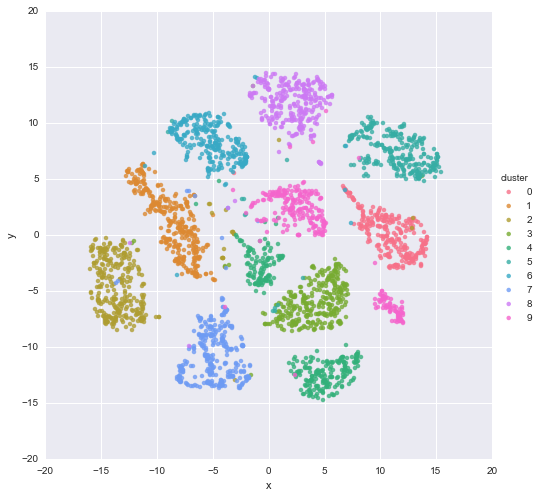

In [19]:
data = {"x": [], "y": [], "cluster": []}
for i in range(len(X_tsne)):
    data["x"].append(Y_tsne[i][0])
    data["y"].append(Y_tsne[i][1])
    data["cluster"].append(y_test[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df,
           fit_reg=False, size=7,
           hue="cluster", legend=True)
plt.show()